In [ ]:
from FISHPainter_package.FISHPainter.src.datasets.create import create_dataset
import numpy as np
from cellplot.patches import gridPlot

In [ ]:
dataset = create_dataset(
    '/home/simon_g/isilon_images_mnt/10_MetaSystems/MetaSystemsData/_simon/src/FISHPainter_package/configs/MYCN.yml',
    FISH_type='COPY_NUMBER',
    background_path=None,
    verbose=True,
    merge_bboxes=False,
    alpha=15,
    sigma=2
)

In [ ]:
patches, masks, parameters, target = [], [], [], [] 
for key, values in dataset.items():
    patches.extend(values['rgb_patches'])
    masks.extend(values['masks'])
    parameters.extend(values['parameters'])
    target.extend(values['target_classes'])

In [ ]:
#gridPlot(patches, hspace=-0.01, vspace=-0.01, plot_size=(20,20))

In [ ]:
parameters = np.array(parameters)

In [ ]:
import h5py

with h5py.File('/home/simon_g/isilon_images_mnt/10_MetaSystems/MetaSystemsData/_simon/data/DiagnosticFISH/test_dataset.h5', 'w') as f:
    f.create_dataset('FISH', data=np.array(patches))
    f.create_dataset('NUCLEUS', data=np.array(masks))
    f.create_dataset('N_SIGNALS', data=np.vstack((parameters[:, 0], parameters[:, 3])).T)

In [ ]:
images, masks = [], []
for k, v in dataset.items():
    images.extend(v['rgb_patches'])
    masks.extend(v['masks'])
    
images = np.array(images)
masks = np.array(masks)

In [54]:
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

def randomly_place_cells(out_size, rgb_images, mask_images, n_images, max_rejections=10, margin=1.1):
    
    hpsz = rgb_images.shape[1] // 2  
    out_image = np.zeros([*np.array(out_size) + 2*hpsz, 3])
    mask_image = np.zeros([*np.array(out_size) + 2*hpsz])
    
    rejection_count = 0  # Counter for consecutive rejections
    placed_cells = 0
    placed_idxs, placed_pos = [], []
    # Loop until all cells are placed or too many rejections occur
    while placed_cells < n_images:
        # Randomly select a cell and calculate its diameter
        if rejection_count == max_rejections:
            print(f'reached max rejections after {placed_cells} cells')
            break
        
        cell_index = np.random.choice(len(rgb_images))

        # Generate a random position
        try_pos = [np.random.randint(hpsz, out_size[0] + hpsz), np.random.randint(hpsz, out_size[1] + hpsz)]
        
        if mask_image[try_pos[0], try_pos[1]] == 1:
            rejection_count += 1 
            continue

        # Check if the new position overlaps with any existing cell
        tmp = np.zeros_like(mask_image)
        rot = np.random.randint(3)
        tmp[try_pos[0]-hpsz:try_pos[0]+hpsz, try_pos[1]-hpsz:try_pos[1]+hpsz] = np.rot90(mask_images[cell_index], k=rot)
        if np.any((mask_image + tmp) > 1):
            rejection_count += 1 
            continue
        
        mask_image = mask_image + tmp
        
        out_image[
            try_pos[0]-hpsz:try_pos[0]+hpsz,
            try_pos[1]-hpsz:try_pos[1]+hpsz
        ] += np.rot90(rgb_images[cell_index], k=rot)

        placed_cells += 1
        
        placed_idxs.append(cell_index)
        placed_pos.append([try_pos[0]-hpsz, try_pos[1]-hpsz])

    return np.clip(out_image[hpsz:-hpsz, hpsz:-hpsz], 0, 1), placed_idxs, placed_pos

# Example Usage

# Assuming `rgb_images` and `mask_images` are provided as lists of arrays

In [55]:
from DiagnosticFISH_package.DiagnosticFISH.src.utils import get_model_dataloader, run_model
from DiagnosticFISH_package.DiagnosticFISH.src.dataset import SingleChannelDataset
from mmengine.dataset import DefaultSampler, default_collate
from torch.utils.data import DataLoader
from mmselfsup.datasets.transforms import PackSelfSupInputs
from DiagnosticFISH_package.DiagnosticFISH.src.transforms import CentralCutter, C_TensorCombiner


cuda = 'cuda:2'

model, _, _ = get_model_dataloader(
    "/home/simon_g/isilon_images_mnt/10_MetaSystems/MetaSystemsData/_simon/src/mmselfsup_package/tools/work_dirs/home/config", 
    num_worker=16,
    batch_size=64,
    device=cuda,
    meta_keys=['n_signals', 'size_nucleus'],
)

pipeline = [
    C_TensorCombiner(),
    CentralCutter(size=128), 
    PackSelfSupInputs(meta_keys=[])
]

dataset = SingleChannelDataset(
    '/home/simon_g/isilon_images_mnt/10_MetaSystems/MetaSystemsData/_simon/data/DiagnosticFISH/classifier_dataset.h5',
    shuffle=False,
    pipeline=pipeline,
    channel_idx=1)

dataloader = DataLoader(
        dataset=dataset, 
        sampler=DefaultSampler(dataset, shuffle=False), 
        batch_size=64, 
        collate_fn=default_collate,
        num_workers=16
    )

model.eval();

ret = run_model(model, dataloader, n_samples=10_000, get_images=True)

/home/simon_g/isilon_images_mnt/10_MetaSystems/MetaSystemsData/_simon/src/mmselfsup_package/tools/work_dirs/home/config/20250303_163649/vis_data/config.py
Loading Model from: /home/simon_g/isilon_images_mnt/10_MetaSystems/MetaSystemsData/_simon/src/mmselfsup_package/tools/work_dirs/home/config/iter_2000.pth
Loads checkpoint by local backend from path: /home/simon_g/isilon_images_mnt/10_MetaSystems/MetaSystemsData/_simon/src/mmselfsup_package/tools/work_dirs/home/config/iter_2000.pth
<re.Match object; span=(21, 29), match='size=128'>
<re.Match object; span=(29, 37), match='size=128'>
<re.Match object; span=(13, 21), match='size=128'>
H5-File: /home/simon_g/isilon_images_mnt/10_MetaSystems/MetaSystemsData/_simon/data/DiagnosticFISH/training_dataset.h5
H5-File: /home/simon_g/isilon_images_mnt/10_MetaSystems/MetaSystemsData/_simon/data/DiagnosticFISH/classifier_dataset.h5


100%|██████████| 32/32 [00:06<00:00,  5.03it/s]


In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# **1️⃣ Create a Simple Binary Classifier**
class BinaryClassifier(nn.Module):
    def __init__(self, input_size=2048):
        super(BinaryClassifier, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()  # Output probability between 0 and 1
        )

    def forward(self, x):
        return self.fc(x)

# **2️⃣ Generate Dummy Data**
X = torch.tensor(np.array(ret['embeddings'].tolist()).mean(axis=(2,3)))
y = torch.tensor(target).unsqueeze(1).float()

# **3️⃣ Create DataLoader**
dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# **4️⃣ Initialize Model, Loss, and Optimizer**
model = BinaryClassifier()
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# **5️⃣ Train the Model**
num_epochs = 3
for epoch in range(num_epochs):
    for batch_X, batch_y in dataloader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

# **6️⃣ Save the Model**
model_path = "/home/simon_g/isilon_images_mnt/10_MetaSystems/MetaSystemsData/_simon/src/Forschungsfest/classifier.pth"
torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': num_epochs}, model_path)
print(f"Model saved to {model_path}")

Epoch 1, Loss: 0.0003
Epoch 2, Loss: 0.0002
Epoch 3, Loss: 0.0007
Model saved to /home/simon_g/isilon_images_mnt/10_MetaSystems/MetaSystemsData/_simon/src/Forschungsfest/classifier.pth


In [57]:
# **7️⃣ Load the Model**
def load_model(model_path, input_size=2048):
    model = BinaryClassifier(input_size)
    optimizer = optim.Adam(model.parameters(), lr=0.001)  # Define optimizer again

    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])

    model.eval()  # Set model to evaluation mode
    return model

In [58]:
from DiagnosticFISH_package.DiagnosticFISH.src.utils import get_model_dataloader, run_model
from DiagnosticFISH_package.DiagnosticFISH.src.dataset import SingleChannelDataset
from mmengine.dataset import DefaultSampler, default_collate
from torch.utils.data import DataLoader
from mmselfsup.datasets.transforms import PackSelfSupInputs
from DiagnosticFISH_package.DiagnosticFISH.src.transforms import CentralCutter, C_TensorCombiner


cuda = 'cuda:2'

model, _, _ = get_model_dataloader(
    "/home/simon_g/isilon_images_mnt/10_MetaSystems/MetaSystemsData/_simon/src/mmselfsup_package/tools/work_dirs/home/config", 
    num_worker=16,
    batch_size=64,
    device=cuda,
    meta_keys=['n_signals', 'size_nucleus'],
)

pipeline = [
    C_TensorCombiner(),
    CentralCutter(size=128), 
    PackSelfSupInputs(meta_keys=[])
]

classifier = load_model("/home/simon_g/isilon_images_mnt/10_MetaSystems/MetaSystemsData/_simon/src/Forschungsfest/classifier.pth")

/home/simon_g/isilon_images_mnt/10_MetaSystems/MetaSystemsData/_simon/src/mmselfsup_package/tools/work_dirs/home/config/20250303_163649/vis_data/config.py
Loading Model from: /home/simon_g/isilon_images_mnt/10_MetaSystems/MetaSystemsData/_simon/src/mmselfsup_package/tools/work_dirs/home/config/iter_2000.pth
Loads checkpoint by local backend from path: /home/simon_g/isilon_images_mnt/10_MetaSystems/MetaSystemsData/_simon/src/mmselfsup_package/tools/work_dirs/home/config/iter_2000.pth
<re.Match object; span=(21, 29), match='size=128'>
<re.Match object; span=(29, 37), match='size=128'>
<re.Match object; span=(13, 21), match='size=128'>
H5-File: /home/simon_g/isilon_images_mnt/10_MetaSystems/MetaSystemsData/_simon/data/DiagnosticFISH/training_dataset.h5


reached max rejections after 82 cells
(900, 1600, 3)
H5-File: /home/simon_g/isilon_images_mnt/10_MetaSystems/MetaSystemsData/_simon/data/DiagnosticFISH/test_dataset.h5


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


torch.Size([82, 2048])


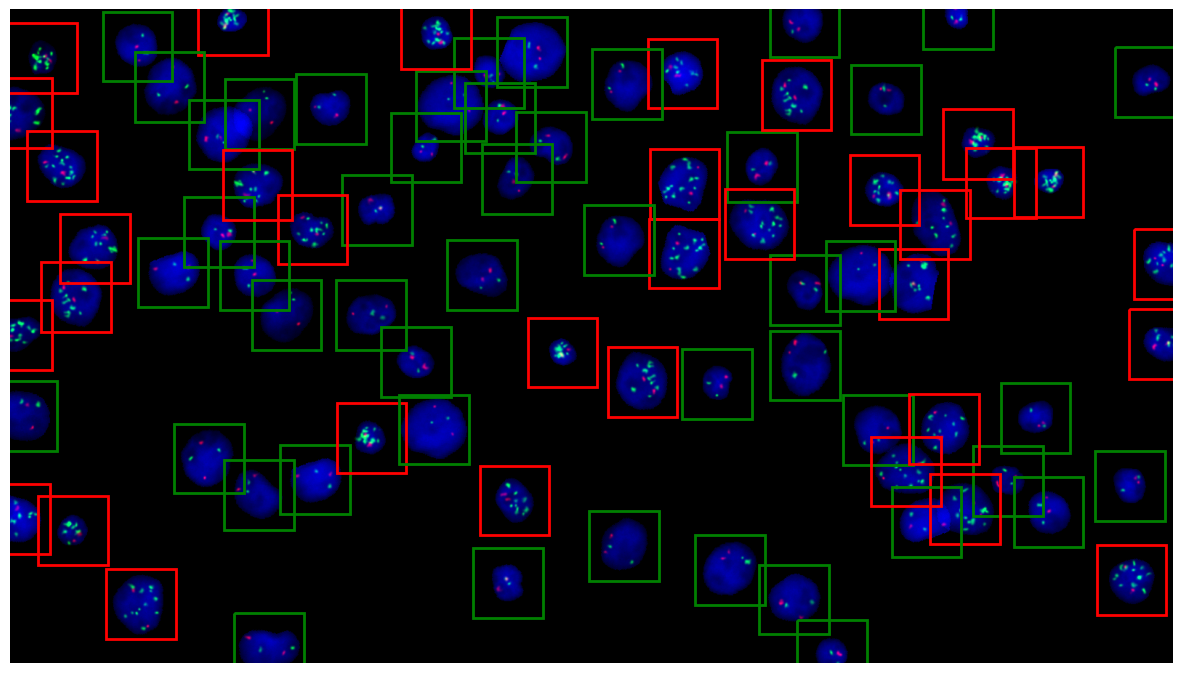

In [64]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

out_size = (900, 1600)

for i in range(3):
    
    n_images = 200 * (i + 1)
    
    # Generate the composite image and get positions
    output, placed_idxs, placed_pos = randomly_place_cells(out_size, images, masks, n_images, max_rejections=50)

    # Display the composite image
    print(output.shape)
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.imshow(output)
    ax.axis('off')

    # Load dataset
    dataset = SingleChannelDataset(
        '/home/simon_g/isilon_images_mnt/10_MetaSystems/MetaSystemsData/_simon/data/DiagnosticFISH/test_dataset.h5',
        shuffle=False,
        pipeline=pipeline,
        channel_idx=1,
        masked_idxs=placed_idxs)

    dataloader = DataLoader(
        dataset=dataset, 
        sampler=DefaultSampler(dataset, shuffle=False), 
        batch_size=64, 
        collate_fn=default_collate,
        num_workers=16
    )

    # Set model to evaluation mode
    model.eval()

    # Run model
    ret = run_model(model, dataloader, n_samples=500, get_images=True)

    # Convert embeddings to tensor
    X = torch.tensor(np.array(ret['embeddings'].tolist()).mean(axis=(2,3)))
    print(X.shape)

    # Get predictions
    pred = classifier(X)  # Predicted probabilities
    pred_labels = (pred > 0.5).int().cpu().numpy().flatten()  # Convert to binary labels (0 or 1)

    # **Overlay squares based on predictions**
    square_size = 96  # Size of the squares

    for pos, label in zip(placed_pos, pred_labels):
        color = "green" if label == 0 else "red"  # Green for 0, Red for 1
        rect = patches.Rectangle(
            (pos[1] - square_size // 2, pos[0] - square_size // 2),  # Center the square
            square_size, square_size, linewidth=2, edgecolor=color, facecolor='none'
        )
        ax.add_patch(rect)

    plt.show()
    
    break  # Only process the first iteration